# **Homework 5 - Sequence-to-sequence**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

### (4/14 Updates) 
1. Link to tutorial [video](https://youtu.be/htG5WpZVQPU).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence 介紹
- 大多數常見的 seq2seq model 為 encoder-decoder model，主要由兩個部分組成，分別是 encoder 和 decoder，而這兩個部可以使用 recurrent neural network (RNN)或 transformer 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將一連串的輸入，如文字、影片、聲音訊號等，編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 encoder 輸出的單個向量逐步解碼，一次輸出一個結果，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - 訓練一個 RNN 模型達到 Seq2seq 翻譯
  - 訓練一個 Transformer 大幅提升效能
  - 實作 Back-translation 大幅提升效能

In [1]:
! nvidia-smi

Mon Apr 26 08:33:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 下載和引入需要的函式庫

In [3]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 901kB 18.3MB/s 
     |████████████████████████████████| 1.2MB 31.7MB/s 
     |████████████████████████████████| 2.1MB 60.0MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 133kB 61.4MB/s 
     |████████████████████████████████| 163kB 57.2MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=8e5165d2656abe99c66c24185f21b99a1b5aaeec27bafbee19d1d288d821aa86
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=924391002417afd7ce667b54b1fe740923fe355c1c1c9bea6cd16c2bc7b3ae35
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subpr

In [4]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into 'fairseq'...
remote: Enumerating objects: 27710, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 27710 (delta 60), reused 99 (delta 54), pack-reused 27579
Receiving objects: 100% (27710/27710), 11.54 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (20879/20879), done.
Note: checking out '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... don

In [5]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 設定種子

In [6]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 資料集介紹

## 英轉繁雙語資料
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - 原始資料量: 398,066句    
    - 處理後資料: 393,980句
    

## 測試資料
- 資料量: 4,000句
- **中文部分不公開，提供的檔案為假翻譯，全部都是句點。**

# 資料下載

### 安裝megatools (optional)

In [ ]:
#!apt-get install megatools

## 下載檔案並解壓縮

In [7]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

--2021-04-26 08:35:34--  https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://yva8og.dm.files.1drv.com/y4mvGHJ8tXBnVpd1o_H_sMhjK8mWpnRhhQzdk4TsrMpR1QgbzheEnpw_0RYVb1p6vZSR_NjHMPdDgAIFnHNc5Hc_GNknAaDRm4d7WgdotCDi_mXf1ZWaNcb5r_3ma5xj5XBUubtOD3G2uEnbAhdKD25WuvNRP6lSqqkPpXNEO1MoOffGwY5bj1E94oh4ttRg_iasCYlxK0qeQLh47_-f0_62Q/ted2020.tgz?download&psid=1 [following]
--2021-04-26 08:35:34--  https://yva8og.dm.files.1drv.com/y4mvGHJ8tXBnVpd1o_H_sMhjK8mWpnRhhQzdk4TsrMpR1QgbzheEnpw_0RYVb1p6vZSR_NjHMPdDgAIFnHNc5Hc_GNknAaDRm4d7WgdotCDi_mXf1ZWaNcb5r_3ma5xj5XBUubtOD3G2uEnbAhdKD25WuvNRP6lSqqkPpXNEO1MoOffGwY5bj1E94oh4ttRg_iasCYlxK0qeQLh47_-f0_62Q/ted2020.tgz?download&psid=1
Resolving yva8og.dm.files.1drv.com (yva8og.dm.files.1drv.com).

## 設定語言

In [8]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [9]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## 檔案前處理

In [10]:
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [11]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [12]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## 切出 train/valid set

In [13]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [14]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

## Subword Units 
翻譯存在的一大問題是未登錄詞(out of vocabulary)，可以使用 subword units 作為斷詞單位來解決。
- 使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 套件
- 用 unigram 或 byte-pair encoding (BPE)

In [15]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

In [16]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [17]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁ ; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁ 。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁ 。 ▁我 非常 感 激 ▁ 。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對 我 之前 演講 的 好 評 ▁ 。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁ !
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁ !


## 用 fairseq 將資料轉為 binary

In [18]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

2021-04-26 08:39:14 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/ted2020', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcdict=None, suppress_crashes=False, target_lang='zh', task='translation', tensorboard_logdir=None, testpref='/content/DATA/rawdata/ted2020/test', tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, t

# 實驗的參數設定表

In [19]:
 !cp -r /content/drive/MyDrive/MLHw5/checkpoints/with_mono13  ./ 

In [82]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    # savedir = "./checkpoints/rnn",
    savedir = "/content/drive/MyDrive/MLHw5/checkpoints/with_mono14",
    source_lang = "en",
    target_lang = "zh",
    # source_lang = "zh", # Back translation
    # target_lang = "en", # Back translation
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30 ,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    # resume= False,
    resume='/content/with_mono13/avg_last_5_checkpoint.pt',  # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging 套件紀錄一般訊息
- wandb 紀錄續練過程 loss, bleu, model weight 等等

In [83]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA環境

In [84]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-04-26 12:15:45 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-04-26 12:15:45 | INFO | fairseq.utils | rank   0: capabilities =  7.0  ; total memory = 15.782 GB ; name = Tesla V100-SXM2-16GB                    
2021-04-26 12:15:45 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 讀取資料集

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [85]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-26 12:15:45 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-04-26 12:15:45 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [86]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-26 12:15:47 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-26 12:15:47 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2021-04-26 12:15:47 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2021-04-26 12:15:47 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2021-04-26 12:15:47 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2021-04-26 12:15:47 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2021-04-26 12:15:47 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 781713 examples
2021-04-26 12:15:47 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.en-zh.en
2021-04-26 12:15:47 | I

In [87]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2218,   60,   19,   75,    4,  253,   16,  334, 1392,
        1689,    7,    2]),
 'target': tensor([ 145,  684,   30,  270,   40,  168, 1134,  650,  591,  367, 3117, 2417,
        1420,  194,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


## Dataset Iterator

* 將每個 batch 控制在 N 個 token 讓 GPU 記憶體更有效被利用
* 讓 training set 每個 epoch 有不同 shuffling
* 濾掉長度太長的句子
* 將每個 batch 內的句子 pad 成一樣長，好讓 GPU 平行運算
* 加上 eos 並 shift 一格
    - teacher forcing: 為了訓練模型根據prefix生成下個字，decoder的輸入會是輸出目標序列往右shift一格。
    - 一般是會在輸入開頭加個bos token (如下圖)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - fairseq 則是直接把 eos 挪到 beginning，訓練起來效果其實差不多。例如: 
    ```
    # 輸出目標 (target) 和 Decoder輸入 (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [88]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-04-26 12:15:49 | WARNING | fairseq.tasks.fairseq_task | 2,586 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 2444, 135, 3058, 93, 2275, 682, 2649, 731, 1623]


{'id': tensor([3200,  828]),
 'net_input': {'prev_output_tokens': tensor([[   2,    4,  237, 1769,    9,  494,  491,  670,    4,   10,    1,    1,
              1,    1,    1,    1],
          [   2,    4,  325, 1974,  793,  294,  289,  596,    4,   10,    1,    1,
              1,    1,    1,    1]]),
  'src_lengths': tensor([8, 8]),
  'src_tokens': tensor([[ 159, 2479,   17,  131,   72,  733,    7,    2],
          [  81,    4, 1709,    4,  862,  718,    7,    2]])},
 'nsentences': 2,
 'ntokens': 20,
 'target': tensor([[   4,  237, 1769,    9,  494,  491,  670,    4,   10,    2,    1,    1,
             1,    1,    1,    1],
         [   4,  325, 1974,  793,  294,  289,  596,    4,   10,    2,    1,    1,
             1,    1,    1,    1]])}

* 每個 batch 是一個字典，key 是字串，value 是 Tensor，內容說明如下
```python
batch = {
    "id": id, # 每個 example 的 id
    "nsentences": len(samples), # batch size 句子數
    "ntokens": ntokens, # batch size 字數
    "net_input": {
        "src_tokens": src_tokens, # 來源語言的序列
        "src_lengths": src_lengths, # 每句話沒有 pad 過的長度
        "prev_output_tokens": prev_output_tokens, # 上面提到右 shift 一格後的目標序列 teacher-forcing
    },
    "target": target, # 目標序列
}
```

# 定義模型架構
* 我們一樣繼承 fairseq 的 encoder, decoder 和 model, 這樣測試階段才能直接用他寫好的 beam search 函式

In [89]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder 編碼器

- seq2seq 模型的編碼器為 RNN 或 Transformer Encoder，以下說明以 RNN 為例，Transformer 略有不同。對於每個輸入，Encoder 會輸出一個向量和一個隱藏狀態(hidden state)，並將隱藏狀態用於下一個輸入。換句話說，Encoder 會逐步讀取輸入序列，並在每個 timestep 輸出單個向量，以及在最後 timestep 輸出最終隱藏狀態(content vector)
- 參數:
  - *args*
      - encoder_embed_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用
      - encoder_ffn_embed_dim 是 RNN 輸出和隱藏狀態的維度(hidden dimension)
      - encoder_layers 是 RNN 要疊多少層
      - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
  - *dictionary*: fairseq 幫我們做好的 dictionary. 在此用來得到 padding index，好用來得到 encoder padding mask. 
  - *embed_tokens*: 事先做好的詞嵌入 (nn.Embedding)

- 輸入: 
    - *src_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 
- 輸出: 
    - *outputs*: 最上層 RNN 每個 timestep 的輸出，後續可以用 Attention 再進行處理
    - *final_hiddens*: 每層最終 timestep 的隱藏狀態，將傳遞到 Decoder 進行解碼
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。


In [90]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # 過雙向RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions] 是最上層RNN的輸出
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # 這個beam search時會用到，意義並不是很重要
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 Decoder 更多的資訊
- 根據現在 **Decoder embeddings** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關係的數值來把 Encoder outputs 平均起來作為 **Decoder** RNN 的輸入 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **query** (decoder embeddings) 和 **key** (Encoder outputs) 之間的關係，再對所有算出來的數值做 **softmax** 得到分佈，最後根據這個分佈對 **values** (Encoder outputs) 做 **weight sum**

- 參數:
  - *input_embed_dim*: key 的維度，應是 decoder 要做 attend 時的向量的維度
  - *source_embed_dim*: query 的維度，應是要被 attend 的向量(encoder outputs)的維度
  - *output_embed_dim*: value 的維度，應是做完 attention 後，下一層預期的向量維度

- 輸入: 
    - *inputs*: 就是 key，要 attend 別人的向量
    - *encoder_outputs*: 是 query/value，被 attend 的向量
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。
- 輸出: 
    - *output*: 做完 attention 後的 context vector
    - *attention score*: attention 的分布


In [91]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # 投影到encoder_outputs的維度
        x = self.input_proj(inputs)

        # 計算attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # 擋住padding位置的attention
        if encoder_padding_mask is not None:
            # 利用broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # 在source對應維度softmax
        attn_scores = F.softmax(attn_scores, dim=-1)

        # 形狀 (B, T, S) x (B, S, dim) = (B, T, dim) 加權平均
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # 回復形狀 (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder 解碼器

* 解碼器的 hidden states 會用編碼器最終隱藏狀態來初始化(content vector)
* 解碼器同時也根據目前 timestep 的輸入(也就是前幾個 timestep 的 output)，改變 hidden states，並輸出結果 
* 如果加入 attention 可以使表現更好
* 我們把 seq2seq 步驟寫在解碼器裡，好讓等等 Seq2Seq 這個型別可以通用 RNN 和 Transformer，而不用再改寫
- 參數:
  - *args*
      - decoder_embed_dim 是解碼器 embedding 的維度，類同 encoder_embed_dim，
      - decoder_ffn_embed_dim 是解碼器 RNN 的隱藏維度，類同 encoder_ffn_embed_dim
      - decoder_layers 解碼器 RNN 的層數
      - share_decoder_input_output_embed 通常 decoder 最後輸出的投影矩陣會和輸入 embedding 共用參數
  - *dictionary*: fairseq 幫我們做好的 dictionary.
  - *embed_tokens*: 事先做好的詞嵌入(nn.Embedding)
- 輸入: 
    - *prev_output_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 已經 shift 一格的 target
    - *encoder_out*: 編碼器的輸出
    - *incremental_state*: 這是測試階段為了加速，所以會記錄每個 timestep 的 hidden state 詳見 forward
- 輸出: 
    - *outputs*: decoder 每個 timestep 的 logits，還沒經過 softmax 的分布
    - *extra*: 沒用到

In [92]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # 取出encoder的輸出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 沒有incremental state代表這是training或者是test time時的第一步
            # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # 做decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # 過單向RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # 投影到vocab size 的分佈
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # 這個beam search時會用到，意義並不是很重要
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- **Decoder** 根據前幾個 timestep 的輸出和 **Encoder** 輸出進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [93]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [94]:
# # HINT: transformer 架構
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

## 設定模型相關參數
參考參數

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

Strong baseline 用的參數可以參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 transformer-base

In [95]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=8,

    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=8,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [96]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [97]:
model = build_model(arch_args, task)
logger.info(model)

2021-04-26 12:16:07 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bia

# Optimization 最佳化

## Loss: Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信
* 有時候Ground Truth並非唯一答案，所以在算loss時，我們會保留一部份機率給正確答案以外的label
* 可以有效防止過度擬合

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [98]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root 排程對於訓練 Transformer 時的穩定性很重要，後來也用在 RNN 上。
根據底下公式來更新 learning rate，前期線性增長，後期根據更新步數方根的倒數來遞減。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [99]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## 排程視覺化

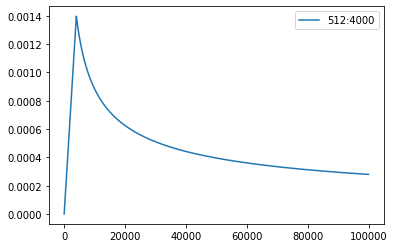

In [100]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 訓練步驟

## Training 訓練

In [101]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓練 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference 檢驗和推論
為防止訓練發生過度擬合，每過一段時間要做一次檢測，計算模型在未看過的資料上的表現。
- 過程基本上和training一樣，另外加上 inference
- 檢驗完畢可順便儲存模型參數

單看 validation loss，我們很難知道模型真實的效能
- 直接用當前模型去生成翻譯結果 (hypothesis)，再和正確答案 (reference) 計算 BLEU score
- 也可用肉眼看翻譯結果的好壞
- 我們用 fairseq 寫好的 sequence generator 來進行 beam search 生成翻譯結果

In [102]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [103]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# 儲存及載入模型參數

In [104]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# 主程式
## 訓練迴圈

In [105]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [47]:
!nvidia-smi

Mon Apr 26 08:43:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    37W / 300W |   1599MiB / 16160MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [106]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-04-26 12:16:20 | INFO | hw5.seq2seq | task: TranslationTask
2021-04-26 12:16:20 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-04-26 12:16:20 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-04-26 12:16:20 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-04-26 12:16:20 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-04-26 12:16:20 | INFO | hw5.seq2seq | num. model params: 67,045,376 (num. trained: 67,045,376)
2021-04-26 12:16:20 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [107]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)  
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-26 12:16:24 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-26 12:16:24 | INFO | hw5.seq2seq | loaded checkpoint /content/with_mono13/avg_last_5_checkpoint.pt: step=56057 loss=2.9148221015930176 bleu=28.74889363628142


2021-04-26 12:31:06 | INFO | hw5.seq2seq | training loss: 2.4902
2021-04-26 12:31:06 | INFO | hw5.seq2seq | begin validation


2021-04-26 12:31:41 | INFO | hw5.seq2seq | example source: and it also suggests that there is something not only in young mouse plasma , but in young human plasma that has the capacity to help this old brain .
2021-04-26 12:31:41 | INFO | hw5.seq2seq | example hypothesis: 這也意味著 , 不僅有年輕的老鼠血漿 , 還有年輕的人類血漿 , 有能力協助老人大腦 。
2021-04-26 12:31:41 | INFO | hw5.seq2seq | example reference: 代表不只是年輕老鼠的血漿裡面 , 年輕人類的血漿裡 , 也有能改善大腦能力的因子 。
2021-04-26 12:31:41 | INFO | hw5.seq2seq | validation loss:	2.9157
2021-04-26 12:31:41 | INFO | hw5.seq2seq | BLEU = 28.94 59.9/35.7/22.5/14.8 (BP = 0.996 ratio = 0.996 hyp_len = 111316 ref_len = 111811)
2021-04-26 12:31:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint1.pt
2021-04-26 12:31:45 | INFO | hw5.seq2seq | end of epoch 1


2021-04-26 12:46:14 | INFO | hw5.seq2seq | training loss: 2.4885
2021-04-26 12:46:14 | INFO | hw5.seq2seq | begin validation


2021-04-26 12:46:49 | INFO | hw5.seq2seq | example source: thank you .
2021-04-26 12:46:49 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2021-04-26 12:46:49 | INFO | hw5.seq2seq | example reference: 謝謝各位 。
2021-04-26 12:46:49 | INFO | hw5.seq2seq | validation loss:	2.9163
2021-04-26 12:46:49 | INFO | hw5.seq2seq | BLEU = 28.87 59.8/35.6/22.3/14.7 (BP = 0.999 ratio = 0.999 hyp_len = 111753 ref_len = 111811)
2021-04-26 12:46:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint2.pt
2021-04-26 12:46:54 | INFO | hw5.seq2seq | end of epoch 2


2021-04-26 13:01:24 | INFO | hw5.seq2seq | training loss: 2.4841
2021-04-26 13:01:24 | INFO | hw5.seq2seq | begin validation


2021-04-26 13:01:59 | INFO | hw5.seq2seq | example source: it's boosted to nearspace atop a minotaur iv rocket .
2021-04-26 13:01:59 | INFO | hw5.seq2seq | example hypothesis: 它被推進到近太空中一個minotauriv火箭 。
2021-04-26 13:01:59 | INFO | hw5.seq2seq | example reference: 架設在一枚彌樂陀4號火箭上推進到近太空 。
2021-04-26 13:01:59 | INFO | hw5.seq2seq | validation loss:	2.9074
2021-04-26 13:01:59 | INFO | hw5.seq2seq | BLEU = 28.86 60.1/35.7/22.4/14.7 (BP = 0.995 ratio = 0.995 hyp_len = 111202 ref_len = 111811)
2021-04-26 13:02:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint3.pt
2021-04-26 13:02:01 | INFO | hw5.seq2seq | end of epoch 3


2021-04-26 13:16:33 | INFO | hw5.seq2seq | training loss: 2.4793
2021-04-26 13:16:33 | INFO | hw5.seq2seq | begin validation


2021-04-26 13:17:08 | INFO | hw5.seq2seq | example source: i would even say that with viagra , estrogen replacement , hip replacements and the incredibly interesting women women have never been as interesting as they are now .
2021-04-26 13:17:08 | INFO | hw5.seq2seq | example hypothesis: 我甚至會說 , 用viagra , 雌激素替換 , 髖關節置換 , 以及非常有趣的女性從來沒有像現在這麼有趣過 。
2021-04-26 13:17:08 | INFO | hw5.seq2seq | example reference: 我甚至認為由於威而鋼、雌激素療法、骨盆腔替換手術的普及 , 以及女人們鮮明有趣的個性女性在歷史上未曾有過如此的一個時代 ,
2021-04-26 13:17:08 | INFO | hw5.seq2seq | validation loss:	2.9068
2021-04-26 13:17:08 | INFO | hw5.seq2seq | BLEU = 28.87 59.9/35.7/22.4/14.8 (BP = 0.996 ratio = 0.996 hyp_len = 111328 ref_len = 111811)
2021-04-26 13:17:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint4.pt
2021-04-26 13:17:11 | INFO | hw5.seq2seq | end of epoch 4


2021-04-26 13:31:44 | INFO | hw5.seq2seq | training loss: 2.4748
2021-04-26 13:31:44 | INFO | hw5.seq2seq | begin validation


2021-04-26 13:32:21 | INFO | hw5.seq2seq | example source: and finally , my most recent image , which has such a special meaning for me personally: this is the serengeti national park in tanzania .
2021-04-26 13:32:21 | INFO | hw5.seq2seq | example hypothesis: 最後 , 我最近的影像 , 這對我個人有這麼特別的意義:這是坦尚尼亞塞倫蓋蒂國家公園 。
2021-04-26 13:32:21 | INFO | hw5.seq2seq | example reference: 最後 , 我最新的影像 , 對我個人有特別的意義:這是位於坦尚尼亞的塞倫蓋提國家公園 。
2021-04-26 13:32:21 | INFO | hw5.seq2seq | validation loss:	2.9159
2021-04-26 13:32:21 | INFO | hw5.seq2seq | BLEU = 28.57 59.5/35.3/22.0/14.4 (BP = 1.000 ratio = 1.010 hyp_len = 112902 ref_len = 111811)
2021-04-26 13:32:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint5.pt
2021-04-26 13:32:23 | INFO | hw5.seq2seq | end of epoch 5


2021-04-26 13:46:55 | INFO | hw5.seq2seq | training loss: 2.4695
2021-04-26 13:46:55 | INFO | hw5.seq2seq | begin validation


2021-04-26 13:47:31 | INFO | hw5.seq2seq | example source: " what a piece of work is a man ! how noble in reason ! "
2021-04-26 13:47:31 | INFO | hw5.seq2seq | example hypothesis: 「 什麼作品是男人 ! 理智有多高 ! 」
2021-04-26 13:47:31 | INFO | hw5.seq2seq | example reference: 「 人類真是完美 ! 理性多麼高貴 ! 」
2021-04-26 13:47:31 | INFO | hw5.seq2seq | validation loss:	2.9056
2021-04-26 13:47:31 | INFO | hw5.seq2seq | BLEU = 28.97 59.7/35.6/22.4/14.8 (BP = 1.000 ratio = 1.004 hyp_len = 112233 ref_len = 111811)
2021-04-26 13:47:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint6.pt
2021-04-26 13:47:34 | INFO | hw5.seq2seq | end of epoch 6


2021-04-26 14:02:04 | INFO | hw5.seq2seq | training loss: 2.4653
2021-04-26 14:02:04 | INFO | hw5.seq2seq | begin validation


2021-04-26 14:02:38 | INFO | hw5.seq2seq | example source: but how does it do that ? now , that's interesting .
2021-04-26 14:02:38 | INFO | hw5.seq2seq | example hypothesis: 但這是怎麼辦到的 ? 現在 , 那很有趣 。
2021-04-26 14:02:38 | INFO | hw5.seq2seq | example reference: 但它怎麼做到的 ? 這就很有趣了 。
2021-04-26 14:02:38 | INFO | hw5.seq2seq | validation loss:	2.9072
2021-04-26 14:02:38 | INFO | hw5.seq2seq | BLEU = 28.81 60.3/36.0/22.6/14.9 (BP = 0.985 ratio = 0.985 hyp_len = 110174 ref_len = 111811)
2021-04-26 14:02:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint7.pt
2021-04-26 14:02:41 | INFO | hw5.seq2seq | end of epoch 7


2021-04-26 14:17:12 | INFO | hw5.seq2seq | training loss: 2.4603
2021-04-26 14:17:12 | INFO | hw5.seq2seq | begin validation


2021-04-26 14:17:47 | INFO | hw5.seq2seq | example source: he played . he won .
2021-04-26 14:17:47 | INFO | hw5.seq2seq | example hypothesis: 他演奏了 , 他贏了
2021-04-26 14:17:47 | INFO | hw5.seq2seq | example reference: 他再開始下棋 , 結果他又贏了 。
2021-04-26 14:17:47 | INFO | hw5.seq2seq | validation loss:	2.8986
2021-04-26 14:17:47 | INFO | hw5.seq2seq | BLEU = 28.92 60.4/36.1/22.8/15.0 (BP = 0.985 ratio = 0.985 hyp_len = 110147 ref_len = 111811)
2021-04-26 14:17:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint8.pt
2021-04-26 14:17:49 | INFO | hw5.seq2seq | end of epoch 8


2021-04-26 14:32:25 | INFO | hw5.seq2seq | training loss: 2.4564
2021-04-26 14:32:25 | INFO | hw5.seq2seq | begin validation


2021-04-26 14:32:59 | INFO | hw5.seq2seq | example source: but instead of making it very literal , showing you exactly the camera tracing , we turned it into a graphic that shows you the basic movement , and shows the way it's being analyzed .
2021-04-26 14:32:59 | INFO | hw5.seq2seq | example hypothesis: 但是 , 與其讓大家清楚地看到攝影機的蹤跡 , 我們把它變成了一張圖表 , 讓你看到基本的動作 , 呈現出它被分析的方式 。
2021-04-26 14:32:59 | INFO | hw5.seq2seq | example reference: 其實這裡並非是原封不動地顯示相機跟踪的物體 , 我們把採集的數據轉化成了影像 , 以便顯示基本的運動和分析的方法 。
2021-04-26 14:32:59 | INFO | hw5.seq2seq | validation loss:	2.9062
2021-04-26 14:32:59 | INFO | hw5.seq2seq | BLEU = 29.13 60.3/36.1/22.8/15.1 (BP = 0.990 ratio = 0.990 hyp_len = 110724 ref_len = 111811)
2021-04-26 14:33:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint9.pt
2021-04-26 14:33:03 | INFO | hw5.seq2seq | end of epoch 9


2021-04-26 14:47:31 | INFO | hw5.seq2seq | training loss: 2.4519
2021-04-26 14:47:31 | INFO | hw5.seq2seq | begin validation


2021-04-26 14:48:04 | INFO | hw5.seq2seq | example source: so if we're not worrying about directing traffic , if we've transcended paper , if we are worrying less about control and more about description , then we can think of the english language as being this beautiful mobile .
2021-04-26 14:48:04 | INFO | hw5.seq2seq | example hypothesis: 所以如果我們不擔心交通流量 , 如果我們用過紙張 , 如果我們比較不擔心控制和描述 , 那我們就可以把英語想像成美麗的手機 。
2021-04-26 14:48:04 | INFO | hw5.seq2seq | example reference: 所以當我們不是在煩惱如何指揮交通時 , 如果我們超越紙張 , 如果我們少煩惱一些關於駕馭的事而多想一些描述 , 那麼我們就可以把英文語言想成一部美麗的轎車 。
2021-04-26 14:48:04 | INFO | hw5.seq2seq | validation loss:	2.9080
2021-04-26 14:48:04 | INFO | hw5.seq2seq | BLEU = 28.97 60.1/35.9/22.6/14.9 (BP = 0.993 ratio = 0.993 hyp_len = 111036 ref_len = 111811)
2021-04-26 14:48:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint10.pt
2021-04-26 14:48:07 | INFO | hw5.seq2seq | end of epoch 10


2021-04-26 15:02:31 | INFO | hw5.seq2seq | training loss: 2.4487
2021-04-26 15:02:31 | INFO | hw5.seq2seq | begin validation


2021-04-26 15:03:04 | INFO | hw5.seq2seq | example source: how do you even start ?
2021-04-26 15:03:04 | INFO | hw5.seq2seq | example hypothesis: 你甚至要如何開始 ?
2021-04-26 15:03:04 | INFO | hw5.seq2seq | example reference: 到底要如何開始 ?
2021-04-26 15:03:04 | INFO | hw5.seq2seq | validation loss:	2.8948
2021-04-26 15:03:04 | INFO | hw5.seq2seq | BLEU = 28.89 60.4/36.1/22.7/15.0 (BP = 0.984 ratio = 0.984 hyp_len = 110048 ref_len = 111811)
2021-04-26 15:03:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint11.pt
2021-04-26 15:03:07 | INFO | hw5.seq2seq | end of epoch 11


2021-04-26 15:17:35 | INFO | hw5.seq2seq | training loss: 2.4443
2021-04-26 15:17:35 | INFO | hw5.seq2seq | begin validation


2021-04-26 15:18:09 | INFO | hw5.seq2seq | example source: so the next time you pass a jewelry shop window displaying a beautifully cut teardropshaped stone , don't be so sure it's just your culture telling you that that sparkling jewel is beautiful .
2021-04-26 15:18:09 | INFO | hw5.seq2seq | example hypothesis: 所以 , 下次你通過珠寶店窗戶展示一塊漂亮的撕碎形狀石頭時 , 不要太確定只是你的文化告訴你 , 閃閃發光的珠寶很漂亮 。
2021-04-26 15:18:09 | INFO | hw5.seq2seq | example reference: 所以下回當你走過珠寶店的櫥窗展示著完美切割淚珠型的寶石別太過肯定那是你的文化教育你那顆閃閃發亮的珠寶是美的表徵
2021-04-26 15:18:09 | INFO | hw5.seq2seq | validation loss:	2.9001
2021-04-26 15:18:09 | INFO | hw5.seq2seq | BLEU = 29.04 60.4/36.1/22.8/15.1 (BP = 0.988 ratio = 0.988 hyp_len = 110460 ref_len = 111811)
2021-04-26 15:18:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint12.pt
2021-04-26 15:18:11 | INFO | hw5.seq2seq | end of epoch 12


2021-04-26 15:32:40 | INFO | hw5.seq2seq | training loss: 2.4409
2021-04-26 15:32:40 | INFO | hw5.seq2seq | begin validation


2021-04-26 15:33:14 | INFO | hw5.seq2seq | example source: chris anderson: so help me out on one thing , because there've been a few augmented reality demos shown over the last year or so out there .
2021-04-26 15:33:14 | INFO | hw5.seq2seq | example hypothesis: 克里斯·安德森:幫我一把 , 因為在過去一年左右 , 已經有一些擴增實境的示範 。
2021-04-26 15:33:14 | INFO | hw5.seq2seq | example reference: 克里斯·安德森:請解答我的一個小疑惑 , 過去一年甚至更久之前就出現過許多擴增實境的展示 ,
2021-04-26 15:33:14 | INFO | hw5.seq2seq | validation loss:	2.8944
2021-04-26 15:33:14 | INFO | hw5.seq2seq | BLEU = 29.05 59.7/35.7/22.5/14.9 (BP = 1.000 ratio = 1.007 hyp_len = 112621 ref_len = 111811)
2021-04-26 15:33:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint13.pt
2021-04-26 15:33:16 | INFO | hw5.seq2seq | end of epoch 13


2021-04-26 15:47:45 | INFO | hw5.seq2seq | training loss: 2.4363
2021-04-26 15:47:45 | INFO | hw5.seq2seq | begin validation


2021-04-26 15:48:20 | INFO | hw5.seq2seq | example source: and in the movie , he plays a downandout lawyer who's become an ambulance chaser .
2021-04-26 15:48:20 | INFO | hw5.seq2seq | example hypothesis: 在電影裡 , 他扮演一個下流的律師 , 他變成了救護車追查員 。
2021-04-26 15:48:20 | INFO | hw5.seq2seq | example reference: 在這部電影裡 , 保羅紐曼飾演一個落魄的律師一個專攬車禍官司的律師
2021-04-26 15:48:20 | INFO | hw5.seq2seq | validation loss:	2.9020
2021-04-26 15:48:20 | INFO | hw5.seq2seq | BLEU = 29.01 60.1/35.9/22.6/14.9 (BP = 0.994 ratio = 0.994 hyp_len = 111121 ref_len = 111811)
2021-04-26 15:48:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint14.pt
2021-04-26 15:48:22 | INFO | hw5.seq2seq | end of epoch 14


2021-04-26 16:02:51 | INFO | hw5.seq2seq | training loss: 2.4335
2021-04-26 16:02:51 | INFO | hw5.seq2seq | begin validation


2021-04-26 16:03:26 | INFO | hw5.seq2seq | example source: now , we could fit more cartoons in the magazine if we removed the articles .
2021-04-26 16:03:26 | INFO | hw5.seq2seq | example hypothesis: 現在 , 如果我們移除文章 , 我們可以在雜誌中塞進更多的漫畫 。
2021-04-26 16:03:26 | INFO | hw5.seq2seq | example reference: 當然我們可以在雜誌中放入更多的漫畫前提是把文章都拿掉
2021-04-26 16:03:26 | INFO | hw5.seq2seq | validation loss:	2.8945
2021-04-26 16:03:26 | INFO | hw5.seq2seq | BLEU = 29.05 60.3/36.1/22.8/15.0 (BP = 0.989 ratio = 0.989 hyp_len = 110629 ref_len = 111811)
2021-04-26 16:03:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint15.pt
2021-04-26 16:03:29 | INFO | hw5.seq2seq | end of epoch 15


2021-04-26 16:17:58 | INFO | hw5.seq2seq | training loss: 2.4284
2021-04-26 16:17:58 | INFO | hw5.seq2seq | begin validation


2021-04-26 16:18:32 | INFO | hw5.seq2seq | example source: and over the years , they've been raising flags , and they haven't been listened to .
2021-04-26 16:18:32 | INFO | hw5.seq2seq | example hypothesis: 這些年來 , 他們一直在籌備國旗 , 也沒聽過 。
2021-04-26 16:18:32 | INFO | hw5.seq2seq | example reference: 這些年來 , 他們一直都在小心提防 , 但沒有人傾聽他們 。
2021-04-26 16:18:32 | INFO | hw5.seq2seq | validation loss:	2.8886
2021-04-26 16:18:32 | INFO | hw5.seq2seq | BLEU = 29.31 60.3/36.2/22.9/15.2 (BP = 0.993 ratio = 0.993 hyp_len = 111061 ref_len = 111811)
2021-04-26 16:18:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint16.pt
2021-04-26 16:18:35 | INFO | hw5.seq2seq | end of epoch 16


2021-04-26 16:33:05 | INFO | hw5.seq2seq | training loss: 2.4257
2021-04-26 16:33:05 | INFO | hw5.seq2seq | begin validation


2021-04-26 16:33:39 | INFO | hw5.seq2seq | example source: let’s go .
2021-04-26 16:33:39 | INFO | hw5.seq2seq | example hypothesis: 開始吧 。
2021-04-26 16:33:39 | INFO | hw5.seq2seq | example reference: 現在
2021-04-26 16:33:39 | INFO | hw5.seq2seq | validation loss:	2.9011
2021-04-26 16:33:39 | INFO | hw5.seq2seq | BLEU = 28.93 60.4/36.2/22.7/15.0 (BP = 0.985 ratio = 0.985 hyp_len = 110104 ref_len = 111811)
2021-04-26 16:33:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint17.pt
2021-04-26 16:33:42 | INFO | hw5.seq2seq | end of epoch 17


2021-04-26 16:48:15 | INFO | hw5.seq2seq | training loss: 2.4222
2021-04-26 16:48:15 | INFO | hw5.seq2seq | begin validation


2021-04-26 16:48:49 | INFO | hw5.seq2seq | example source: i prayed for them , and things started to change .
2021-04-26 16:48:49 | INFO | hw5.seq2seq | example hypothesis: 我為他們禱告 , 事情開始改變 。
2021-04-26 16:48:49 | INFO | hw5.seq2seq | example reference: 我為他們禱告 , 然後事情開始有了轉變 。
2021-04-26 16:48:49 | INFO | hw5.seq2seq | validation loss:	2.8996
2021-04-26 16:48:49 | INFO | hw5.seq2seq | BLEU = 29.19 60.0/35.9/22.6/14.9 (BP = 1.000 ratio = 1.001 hyp_len = 111935 ref_len = 111811)
2021-04-26 16:48:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint18.pt
2021-04-26 16:48:52 | INFO | hw5.seq2seq | end of epoch 18


2021-04-26 17:03:20 | INFO | hw5.seq2seq | training loss: 2.4188
2021-04-26 17:03:20 | INFO | hw5.seq2seq | begin validation


2021-04-26 17:03:53 | INFO | hw5.seq2seq | example source: if you think nursery , kindergarten , first years of school are just dedicated to take away the children , to make them used to staying long hours away from their family .
2021-04-26 17:03:53 | INFO | hw5.seq2seq | example hypothesis: 如果你認為養育子女、幼稚園 , 第一年的學校 , 只是奉獻要帶走孩子 , 讓他們習慣長時間離家 。
2021-04-26 17:03:53 | INFO | hw5.seq2seq | example reference: 你想想托兒所、幼稚園、小學一年級 , 都極力想把孩子帶走 , 讓他們適應長時間地離開家庭 。
2021-04-26 17:03:53 | INFO | hw5.seq2seq | validation loss:	2.8975
2021-04-26 17:03:53 | INFO | hw5.seq2seq | BLEU = 29.23 60.4/36.2/22.8/15.2 (BP = 0.991 ratio = 0.991 hyp_len = 110818 ref_len = 111811)
2021-04-26 17:03:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint19.pt
2021-04-26 17:03:55 | INFO | hw5.seq2seq | end of epoch 19


2021-04-26 17:18:16 | INFO | hw5.seq2seq | training loss: 2.4162
2021-04-26 17:18:16 | INFO | hw5.seq2seq | begin validation


2021-04-26 17:18:48 | INFO | hw5.seq2seq | example source: we don't value our own traditional knowledge .
2021-04-26 17:18:48 | INFO | hw5.seq2seq | example hypothesis: 我們不重視自己的傳統知識
2021-04-26 17:18:48 | INFO | hw5.seq2seq | example reference: 不珍視自己的傳統知識 ,
2021-04-26 17:18:48 | INFO | hw5.seq2seq | validation loss:	2.8881
2021-04-26 17:18:48 | INFO | hw5.seq2seq | BLEU = 29.15 60.6/36.4/23.0/15.3 (BP = 0.982 ratio = 0.983 hyp_len = 109861 ref_len = 111811)
2021-04-26 17:18:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint20.pt
2021-04-26 17:18:52 | INFO | hw5.seq2seq | end of epoch 20


2021-04-26 17:33:13 | INFO | hw5.seq2seq | training loss: 2.4124
2021-04-26 17:33:13 | INFO | hw5.seq2seq | begin validation


2021-04-26 17:33:46 | INFO | hw5.seq2seq | example source: meanwhile , they're not safe , and they have no access to lawyers .
2021-04-26 17:33:46 | INFO | hw5.seq2seq | example hypothesis: 同時 , 他們也不安全 , 他們也沒有律師的管道 。
2021-04-26 17:33:46 | INFO | hw5.seq2seq | example reference: 在這期間 , 他們並不安全 , 且他們沒有任何律師協助 。
2021-04-26 17:33:46 | INFO | hw5.seq2seq | validation loss:	2.8839
2021-04-26 17:33:46 | INFO | hw5.seq2seq | BLEU = 29.13 60.4/36.2/22.8/15.1 (BP = 0.989 ratio = 0.989 hyp_len = 110576 ref_len = 111811)
2021-04-26 17:33:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint21.pt
2021-04-26 17:33:48 | INFO | hw5.seq2seq | end of epoch 21


2021-04-26 17:48:17 | INFO | hw5.seq2seq | training loss: 2.4104
2021-04-26 17:48:17 | INFO | hw5.seq2seq | begin validation


2021-04-26 17:48:51 | INFO | hw5.seq2seq | example source: and so i then moved on into my design career and began to find some exciting things .
2021-04-26 17:48:51 | INFO | hw5.seq2seq | example hypothesis: 於是我開始了我的設計生涯 , 開始發現一些令人興奮的事 。
2021-04-26 17:48:51 | INFO | hw5.seq2seq | example reference: 就這樣 , 在我投身設計事業而且越做越深入的過程中 , 我開始發現一些令人興奮的東西 。
2021-04-26 17:48:51 | INFO | hw5.seq2seq | validation loss:	2.8920
2021-04-26 17:48:51 | INFO | hw5.seq2seq | BLEU = 29.16 60.0/35.9/22.7/15.0 (BP = 0.997 ratio = 0.997 hyp_len = 111466 ref_len = 111811)
2021-04-26 17:48:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint22.pt
2021-04-26 17:48:53 | INFO | hw5.seq2seq | end of epoch 22


2021-04-26 18:03:16 | INFO | hw5.seq2seq | training loss: 2.4064
2021-04-26 18:03:16 | INFO | hw5.seq2seq | begin validation


2021-04-26 18:03:48 | INFO | hw5.seq2seq | example source: i'm just going to very briefly show you three games that i've made that are an attempt to give people the means to create epic wins in their own futures .
2021-04-26 18:03:48 | INFO | hw5.seq2seq | example hypothesis: 我將簡短的介紹三個我製作的遊戲這些遊戲嘗試給人們創造史詩般的勝利方法
2021-04-26 18:03:48 | INFO | hw5.seq2seq | example reference: 我來簡短的介紹一下這三款我設計的遊戲目的是想給人們一些能用來達成自己未來史詩勝利所需要的道具這是《無油世界》
2021-04-26 18:03:48 | INFO | hw5.seq2seq | validation loss:	2.8985
2021-04-26 18:03:48 | INFO | hw5.seq2seq | BLEU = 29.13 60.6/36.3/22.9/15.2 (BP = 0.986 ratio = 0.986 hyp_len = 110265 ref_len = 111811)
2021-04-26 18:03:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint23.pt
2021-04-26 18:03:51 | INFO | hw5.seq2seq | end of epoch 23


2021-04-26 18:18:13 | INFO | hw5.seq2seq | training loss: 2.4036
2021-04-26 18:18:13 | INFO | hw5.seq2seq | begin validation


2021-04-26 18:18:47 | INFO | hw5.seq2seq | example source: i'm here to show you how something you can't see can be so much fun to look at .
2021-04-26 18:18:47 | INFO | hw5.seq2seq | example hypothesis: 我來這裡是要讓大家看看 , 你看不到的東西怎麼會這麼好玩 。
2021-04-26 18:18:47 | INFO | hw5.seq2seq | example reference: 我到這裡是來給你們展示那些你看不見的東西是怎樣變得看起來很有趣 。
2021-04-26 18:18:47 | INFO | hw5.seq2seq | validation loss:	2.8920
2021-04-26 18:18:47 | INFO | hw5.seq2seq | BLEU = 29.09 60.6/36.4/23.0/15.2 (BP = 0.982 ratio = 0.982 hyp_len = 109768 ref_len = 111811)
2021-04-26 18:18:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint24.pt
2021-04-26 18:18:49 | INFO | hw5.seq2seq | end of epoch 24


2021-04-26 18:33:13 | INFO | hw5.seq2seq | training loss: 2.4017
2021-04-26 18:33:13 | INFO | hw5.seq2seq | begin validation


2021-04-26 18:33:47 | INFO | hw5.seq2seq | example source: you both won . i congratulate both of you .
2021-04-26 18:33:47 | INFO | hw5.seq2seq | example hypothesis: 你們兩個都贏了 。 我恭喜你們兩個
2021-04-26 18:33:47 | INFO | hw5.seq2seq | example reference: 你們二方都是贏家 , 恭喜你們
2021-04-26 18:33:47 | INFO | hw5.seq2seq | validation loss:	2.8908
2021-04-26 18:33:47 | INFO | hw5.seq2seq | BLEU = 29.21 60.0/36.0/22.7/15.1 (BP = 0.996 ratio = 0.996 hyp_len = 111353 ref_len = 111811)
2021-04-26 18:33:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint25.pt
2021-04-26 18:33:50 | INFO | hw5.seq2seq | end of epoch 25


2021-04-26 18:48:13 | INFO | hw5.seq2seq | training loss: 2.3986
2021-04-26 18:48:13 | INFO | hw5.seq2seq | begin validation


2021-04-26 18:48:46 | INFO | hw5.seq2seq | example source: for example , if one actor says , " here is a pool of water , " and the other actor says , " no , that's just a stage , " the improvisation is over .
2021-04-26 18:48:46 | INFO | hw5.seq2seq | example hypothesis: 舉例來說 , 如果一個演員說: 「 這裡有一個水池 。 」 另一個演員說: 「 不 , 那只是一個舞台 。 」 即興演出就結束了 。
2021-04-26 18:48:46 | INFO | hw5.seq2seq | example reference: 舉例來說如果一個演員說: 「 這裡有一個水池 。 」 而其他演員說: 「 不是啦 ! 這裡是舞台 。 」 這一場即興演出就結束了 ,
2021-04-26 18:48:46 | INFO | hw5.seq2seq | validation loss:	2.8871
2021-04-26 18:48:46 | INFO | hw5.seq2seq | BLEU = 29.30 60.2/36.1/22.9/15.2 (BP = 0.994 ratio = 0.994 hyp_len = 111136 ref_len = 111811)
2021-04-26 18:48:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint26.pt
2021-04-26 18:48:48 | INFO | hw5.seq2seq | end of epoch 26


2021-04-26 19:03:16 | INFO | hw5.seq2seq | training loss: 2.3959
2021-04-26 19:03:16 | INFO | hw5.seq2seq | begin validation


2021-04-26 19:03:51 | INFO | hw5.seq2seq | example source: it's incumbent upon us , and this organization , i believe , to make clarity , transparency and empathy a national priority .
2021-04-26 19:03:51 | INFO | hw5.seq2seq | example hypothesis: 我們不屈不撓 , 這個組織 , 我相信 , 要讓清晰、透明化 , 以及同理心成為國家優先事項 。
2021-04-26 19:03:51 | INFO | hw5.seq2seq | example reference: 因此我相信我們和這個組織有義不容辭的責任讓貫徹明確、一目了然、共識的原則成為全國的優先任務
2021-04-26 19:03:51 | INFO | hw5.seq2seq | validation loss:	2.8904
2021-04-26 19:03:51 | INFO | hw5.seq2seq | BLEU = 29.40 60.3/36.2/23.0/15.3 (BP = 0.993 ratio = 0.993 hyp_len = 111041 ref_len = 111811)
2021-04-26 19:03:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint27.pt
2021-04-26 19:03:55 | INFO | hw5.seq2seq | end of epoch 27


2021-04-26 19:18:26 | INFO | hw5.seq2seq | training loss: 2.3941
2021-04-26 19:18:26 | INFO | hw5.seq2seq | begin validation


2021-04-26 19:19:00 | INFO | hw5.seq2seq | example source: i turn around . . .
2021-04-26 19:19:00 | INFO | hw5.seq2seq | example hypothesis: 我轉過身去......
2021-04-26 19:19:00 | INFO | hw5.seq2seq | example reference: 我回頭
2021-04-26 19:19:00 | INFO | hw5.seq2seq | validation loss:	2.8924
2021-04-26 19:19:00 | INFO | hw5.seq2seq | BLEU = 29.18 60.4/36.1/22.8/15.1 (BP = 0.990 ratio = 0.991 hyp_len = 110750 ref_len = 111811)
2021-04-26 19:19:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint28.pt
2021-04-26 19:19:02 | INFO | hw5.seq2seq | end of epoch 28


2021-04-26 19:33:34 | INFO | hw5.seq2seq | training loss: 2.3908
2021-04-26 19:33:34 | INFO | hw5.seq2seq | begin validation


2021-04-26 19:34:07 | INFO | hw5.seq2seq | example source: as you might see the bottom of the list was climate change .
2021-04-26 19:34:07 | INFO | hw5.seq2seq | example hypothesis: 你們可能看到清單的底部是氣候變遷 。
2021-04-26 19:34:07 | INFO | hw5.seq2seq | example reference: 可以看見清單最末是氣候變遷
2021-04-26 19:34:07 | INFO | hw5.seq2seq | validation loss:	2.8851
2021-04-26 19:34:07 | INFO | hw5.seq2seq | BLEU = 29.18 61.1/36.7/23.3/15.5 (BP = 0.972 ratio = 0.973 hyp_len = 108761 ref_len = 111811)
2021-04-26 19:34:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint29.pt
2021-04-26 19:34:09 | INFO | hw5.seq2seq | end of epoch 29


2021-04-26 19:48:44 | INFO | hw5.seq2seq | training loss: 2.3884
2021-04-26 19:48:44 | INFO | hw5.seq2seq | begin validation


2021-04-26 19:49:18 | INFO | hw5.seq2seq | example source: so here we are back to the horse and buggy .
2021-04-26 19:49:18 | INFO | hw5.seq2seq | example hypothesis: 現在我們回到馬和馬車上 。
2021-04-26 19:49:18 | INFO | hw5.seq2seq | example reference: 現在回到馬匹及馬車
2021-04-26 19:49:18 | INFO | hw5.seq2seq | validation loss:	2.8876
2021-04-26 19:49:18 | INFO | hw5.seq2seq | BLEU = 29.17 60.6/36.4/23.0/15.3 (BP = 0.983 ratio = 0.983 hyp_len = 109890 ref_len = 111811)
2021-04-26 19:49:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint30.pt
2021-04-26 19:49:21 | INFO | hw5.seq2seq | end of epoch 30


# Submission 繳交檔案

In [108]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['/content/drive/MyDrive/MLHw5/checkpoints/with_mono14'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='/content/drive/MyDrive/MLHw5/checkpoints/with_mono14/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['/content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint30.pt', '/content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint29.pt', '/content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint28.pt', '/content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint27.pt', '/content/drive/MyDrive/MLHw5/checkpoints/with_mono14/checkpoint26.pt']
Finished writing averaged checkpoint to /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/avg_last_5_checkpoint.pt


## 確認生成繳交檔案的模型參數

In [109]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-04-26 19:49:32 | INFO | hw5.seq2seq | loaded checkpoint /content/drive/MyDrive/MLHw5/checkpoints/with_mono14/avg_last_5_checkpoint.pt: step=unknown loss=2.8876028060913086 bleu=29.169233598441384
2021-04-26 19:49:32 | INFO | hw5.seq2seq | begin validation


2021-04-26 19:50:07 | INFO | hw5.seq2seq | example source: and actually , i can relate to the whole like acronym thing and everything .
2021-04-26 19:50:07 | INFO | hw5.seq2seq | example hypothesis: 實際上 , 我可以像縮寫一樣與整個事件相關 。
2021-04-26 19:50:07 | INFO | hw5.seq2seq | example reference: 事實上 , 我也和某些縮寫相關的事很有淵源 。
2021-04-26 19:50:07 | INFO | hw5.seq2seq | validation loss:	2.8762
2021-04-26 19:50:07 | INFO | hw5.seq2seq | BLEU = 29.39 60.7/36.5/23.2/15.4 (BP = 0.986 ratio = 0.986 hyp_len = 110285 ref_len = 111811)


## 進行預測

In [110]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根據 preprocess 時的順序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [111]:
generate_prediction(model, task)

2021-04-26 19:50:07 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.en
2021-04-26 19:50:07 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.zh
2021-04-26 19:50:07 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


In [112]:
!cp /content/prediction.txt /content/drive/MyDrive/MLHw5/

In [113]:
from google.colab import files
files.download("./prediction.txt") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
raise

# Back-translation

## 訓練一個反向的翻譯模型

1. 將實驗的參數設定表中(config)的source_lang與target_lang互相交換
2. 將實驗的參數設定表中(config)的savedir更改(ex. "./checkpoints/rnn-back")
3. 訓練一個反向模型

## 利用反向模型生成額外資料

### 下載 monolingual data

In [77]:
mono_dataset_name = 'mono'

In [78]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

--2021-04-26 12:12:07--  https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zla8og.dm.files.1drv.com/y4mMA-YLSxNQuH4NPnc1okj7NtnU7Zn7UWoECRcCW0XO2R_ZdBaxTSM1Oxo8htiT07IakY5JukMaFB9BTZv6FGb48vRcomvBLHvPKJIJz6Z2LqdzdWk6TSZP_rYSXsBrP_eoMCVsYtzGMaLbm83ZgMxrx9Ozgx6CZxxbyJEMWC0jET7T6QgUrRmK-ixhMXz-sezm6ga4uHhiCrT05BsFIK7cw/ted_zh_corpus.deduped.gz?download&psid=1 [following]
--2021-04-26 12:12:07--  https://zla8og.dm.files.1drv.com/y4mMA-YLSxNQuH4NPnc1okj7NtnU7Zn7UWoECRcCW0XO2R_ZdBaxTSM1Oxo8htiT07IakY5JukMaFB9BTZv6FGb48vRcomvBLHvPKJIJz6Z2LqdzdWk6TSZP_rYSXsBrP_eoMCVsYtzGMaLbm83ZgMxrx9Ozgx6CZxxbyJEMWC0jET7T6QgUrRmK-ixhMXz-sezm6ga4uHhiCrT05BsFIK7cw/ted_zh_corpus.deduped.gz?download&psid=1
Resolving zla8og.dm.files.1drv.com (

In [ ]:
!mv {mono_prefix/'ted_zh_corpus.deduped'} {mono_prefix/'mono.zh'}
!head {mono_prefix/'mono.zh'} -n 5

在 16 世紀中葉 意大利人被一種男歌手迷住了 那種男歌手的音域廣闊，包含的音高 先前是一般成年男性不可能達到的
但是，這天賦有一個很高的代價
要防止他們變聲 這些歌手在青春期前被閹割 來停止荷爾蒙的變化， 以免他們的聲線變低沉
被稱為「閹伶」，他們輕輕的、 天使般的聲音在整個歐洲很有名 直到這個殘酷的程序， 在 19 世紀被禁止
雖然阻止聲帶的成長， 可以產生一個非凡廣闊的音域 但自然發展的聲音， 已經具有極多的可能性


### TODO: 清理資料集

1. 將太長、太短的句子移除
2. 統一標點符號

hint: 可以使用clean_s()來協助

In [ ]:
min_len=1
max_len=1000
l1='zh'
with open('/content/DATA/rawdata/mono/mono.zh', 'r') as l1_in_f:
  with open('/content/DATA/rawdata/mono/mono.clean.zh', 'w') as l1_out_f:
    for s1 in l1_in_f:
        s1 = s1.strip()
        s1 = clean_s(s1, l1)
        s1_len = len_s(s1, l1)
        if min_len > 0: # remove short sentence
            if s1_len < min_len :
                continue
        if max_len > 0: # remove long sentence
            if s1_len > max_len :
                continue
        print(s1, file=l1_out_f)

In [ ]:
!head {'/content/DATA/rawdata/mono/mono.clean.zh'} -n 5

在16世紀中葉意大利人被一種男歌手迷住了那種男歌手的音域廣闊 , 包含的音高先前是一般成年男性不可能達到的
但是 , 這天賦有一個很高的代價
要防止他們變聲這些歌手在青春期前被閹割來停止荷爾蒙的變化 , 以免他們的聲線變低沉
被稱為 「 閹伶 」 , 他們輕輕的、天使般的聲音在整個歐洲很有名直到這個殘酷的程序 , 在19世紀被禁止
雖然阻止聲帶的成長 , 可以產生一個非凡廣闊的音域但自然發展的聲音 , 已經具有極多的可能性


### TODO: Subword Units

用反向模型的 spm model 將資料切成 subword units

hint: spm model 的路徑為 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [ ]:
!cp /content/drive/MyDrive/MLHw5/backward1/mono.en  /content/DATA/rawdata/mono/mono.en

In [ ]:
import sentencepiece as spm
prefix = Path(data_dir).absolute() / mono_dataset_name
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join(['/content/DATA/rawdata/mono/mono.clean.zh',
                        '/content/DATA/rawdata/mono/mono.en']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

In [ ]:
spm_model = spm.SentencePieceProcessor(model_file='/content/DATA/rawdata/ted2020/spm8000.model')
with open(prefix/f'{mono_dataset_name}.{l1}', 'w') as out_f:
    with open('/content/DATA/rawdata/mono/mono.clean.zh', 'r') as in_f:
      for line in in_f:
          line = line.strip()
          tok = spm_model.encode(line, out_type=str)
          print(' '.join(tok), file=out_f)

In [ ]:
!head {'/content/DATA/rawdata/mono/mono.zh'} -n 5

▁在 16 世紀 中 葉 意 大 利 人 被 一種 男 歌 手 迷 住 了 那種 男 歌 手 的 音 域 廣 闊 ▁, ▁ 包 含 的 音 高 先 前 是 一般 成 年 男性 不可能 達到 的
▁但是 ▁, ▁這 天 賦 有一個 很 高 的 代 價
▁ 要 防 止 他們 變 聲 這些 歌 手 在 青 春 期 前 被 閹 割 來 停 止 荷 爾 蒙 的 變化 ▁, ▁以 免 他們的 聲 線 變 低 沉
▁ 被 稱為 ▁「 ▁ 閹 伶 ▁」 ▁, ▁他們 輕 輕 的 、 天 使 般 的聲音 在 整個 歐 洲 很 有 名 直 到 這個 殘 酷 的 程 序 ▁, ▁在 19 世紀 被 禁 止
▁雖然 阻 止 聲 帶 的 成長 ▁, ▁ 可以 產生 一個 非 凡 廣 闊 的 音 域 但 自然 發展 的聲音 ▁, ▁ 已經 具有 極 多 的 可能 性


### Binarize

使用fairseq將資料轉為binary

In [ ]:
# 生成全為.的mono.en檔案
with open('/content/DATA/rawdata/mono/mono.zh','r') as in_f:
    with open('/content/DATA/rawdata/mono/mono.en', 'w') as out_f:
        for s in in_f:
            s='▁.'
            print(s, file=out_f)

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str('/content/DATA/rawdata/mono/mono') # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

2021-04-21 03:14:08 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/mono', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.en.txt', threshold_lo

### TODO: 生成反向翻譯資料

將 binarized data 加入原本的資料夾中並用一個 split_name 取名

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

便可以使用 generate_prediction(model, task, split="split_name")來產生翻譯資料

In [ ]:
# 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
!cp -r /content/drive/MyDrive/MLHw5/checkpoints/back  ./ 

In [ ]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file
generate_prediction(model,task, split='mono', outfile="/content/DATA/rawdata/mono/mono.en")

2021-04-20 15:50:34 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2021-04-20 15:50:34 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2021-04-20 15:50:34 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 781713 examples


In [ ]:
from google.colab import files
files.download("/content/DATA/rawdata/mono/mono.en") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TODO: 產生新的dataset

1. 將翻譯出來的資料與原先的訓練資料結合
2. 使用之前的spm model切出成Subword Units
3. 重新使用fairseq將資料轉為binary

In [ ]:
!head {'/content/drive/MyDrive/MLHw5/backward1/mono.en'} -n 5

in the middle of the 16th century , italians were obsessed with a man singer , a wide spread of the singer , including the sounds of the adults .
but there's a very high cost for this gift .
to prevent them from singinging , these singers were castrated before they were castrated to stop hormones in order to stop their voices .
it's called " castrain , angels , " which are very famous in europe until this brutal process was banned in the 19th century .
although the growth of sound can produce an extraordinary field of sound , the sound of natural development has a lot of possibilities .


In [ ]:
l2='tok.en'
with open(prefix/f'{mono_dataset_name}.{l2}', 'w') as out_f:
    with open('/content/drive/MyDrive/MLHw5/backward1/mono.en', 'r') as in_f:
      for line in in_f:
          line = line.strip()
          tok = spm_model.encode(line, out_type=str)
          print(' '.join(tok), file=out_f)

In [ ]:
!head {'/content/DATA/rawdata/mono/mono.tok.en'} -n 5

▁in ▁the ▁middle ▁of ▁the ▁ 16 th ▁century ▁, ▁it al ian s ▁were ▁ ob s es s ed ▁with ▁a ▁man ▁ s ing er ▁, ▁a ▁ wi de ▁sp re ad ▁of ▁the ▁ s ing er ▁, ▁in c lu d ing ▁the ▁sound s ▁of ▁the ▁a d ul t s ▁.
▁but ▁there ' s ▁a ▁ very ▁high ▁cost ▁for ▁this ▁g if t ▁.
▁to ▁pre v ent ▁them ▁from ▁ s ing ing ing ▁, ▁these ▁ s ing ers ▁were ▁ca s tra ted ▁before ▁they ▁were ▁ca s tra ted ▁to ▁stop ▁ho r mon es ▁in ▁order ▁to ▁stop ▁their ▁voice s ▁.
▁it ' s ▁called ▁ " ▁ca s tra in ▁, ▁ ang el s ▁, ▁ " ▁which ▁are ▁ very ▁f am ous ▁in ▁europe ▁until ▁this ▁br ut al ▁process ▁was ▁ba n ned ▁in ▁the ▁19 th ▁century ▁.
▁a lt ho ugh ▁the ▁grow th ▁of ▁sound ▁can ▁produce ▁an ▁ex tra or d in ary ▁field ▁of ▁sound ▁, ▁the ▁sound ▁of ▁natural ▁develop ment ▁has ▁a ▁lot ▁of ▁po s s ib il ities ▁.


In [79]:
!cp /content/drive/MyDrive/MLHw5/mono.tok.zh /content/DATA/rawdata/mono/mono.tok.zh
!cp /content/drive/MyDrive/MLHw5/backward1/mono.tok.en /content/DATA/rawdata/mono/mono.tok.en

In [ ]:
!cp  /content/DATA/rawdata/mono/mono.tok.zh /content/drive/MyDrive/MLHw5/backward2/mono.tok.zh
!cp  /content/DATA/rawdata/mono/mono.tok.en /content/drive/MyDrive/MLHw5/backward2/mono.tok.en

In [80]:
# 合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)
# 
# hint: 在此用剛剛的 spm model 對 prediction_file 進行切斷詞
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: 在此用 fairseq 把這些檔案再 binarize
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str('./DATA/rawdata/mono/mono.tok') # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

2021-04-26 12:13:11 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/synthetic', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.en.txt', thresho

In [81]:
# 這裡用剛剛準備的檔案合併原先 ted2020 來生成最終 back-translation 的資料
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

### TODO: 重新訓練

當已經產生新的資料集

1. 將實驗的參數設定表(config)中的datadir改為新的資料集("./DATA/data-bin/ted2020_with_mono")
2. 將實驗的參數設定表(config)中的source_lang與target_lang設定還原("en", "zh")
3. 將實驗的參數設定表(config)中的savedir更改(ex. "./checkpoints/rnn-bt")
4. 重新訓練

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html